# Leaky Integrate And Fire Model

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson, mode
from typing import List, Tuple
import scipy
import pandas as pd
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
from pprint import pprint
import math
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [266]:
# https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/1-lif.ipynb

# https://github.com/markstrefford/Spiking-Neural-Network/blob/master/SNN_0.ipynb

# https://github.com/arnaublanco/Integrate-and-Fire-model/blob/main/Integrate-and-fire%20model.ipynb

In [267]:
sample_rate = 1000
signal_length = 1

## Neuron Model

In [268]:
class Neuron:
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda):
        self.v_rest = v_rest
        self.sample_rate = sample_rate
        self.h = 1 / sample_rate
        self.thr = thr
        self.tf = tf
        self.t_ref = t_ref
        self.lmbda = lmbda
        self.length_v = int(tf * sample_rate)
        self.t_ref_i = int(t_ref * sample_rate)
        self.v_values = np.zeros(self.length_v)

    def f(self, t, v):
        I_0 = 0.01
        R = 10**4
        tau = 0.02
        dv_dt = (- (v-self.v_rest) + R * I_0)/tau
        return dv_dt

    def solve_ode(self, y0, t0):
        sol = solve_ivp(self.f, [t0, self.tf], [y0], method='RK45', t_eval=np.linspace(t0, self.tf, 1000))
        return sol.y[0], sol.t
        
    def identify_neuron_spikes(self, neuron_signal) -> List[int]:
        # the positions of the spikes in the signal
        return [i for i, value in enumerate(neuron_signal) if value >= max(neuron_signal)]

    def simulate(self):
        pass

    def plot_signal(self):
        fig, ax = plt.subplots(figsize=(12, 3))
        neuron_signal = self.v_values
        time = np.arange(len(neuron_signal)) / self.sample_rate
        ax.plot(time, neuron_signal, c="k", lw=0.5)
        ax.axhline(y=self.thr, c="grey", linewidth=0.5, ls=":", zorder=0, label=f"threshold {self.thr}")
        fig.legend()
        ax.set_title('Signal Emitted by Neuron')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage (mV)')
        ax.set_xlim(0, np.max(time))
        plt.tight_layout()
        plt.show()

In [269]:
class EulerLIF(Neuron):
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda):
        super().__init__(v_rest, sample_rate, thr, tf, t_ref, lmbda)
        
    def solve_ode(self, y0, t0):
        # uses the euler ODE method
        y_values = []
        t = t0
        y = y0
        while y < self.thr:
            t += self.h
            y += self.h * self.f(t, y)
            y_values.append(y)
        return y_values, t
    
    def simulate(self):
        i = 0
        t = 0
        step = 0
        while i < self.length_v:
            rnd_thr = random.random()
            prob = poisson.cdf(step, mu=self.lmbda)
            step += 1
            if prob < rnd_thr:
                rnd_time = int(self.t_ref_i * 4 * random.random())
                if i + rnd_time < self.length_v:
                    self.v_values[i:i+rnd_time] = self.v_rest
                    i = i + rnd_time
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
            else:
                v_t, t = self.solve_ode(self.v_rest, t)
                new_i = int(round(t / self.h))
                if new_i + self.t_ref_i + 2 <= self.length_v:
                    self.v_values[i:new_i] = v_t
                    i = new_i + 1
                    self.v_values[i] = self.v_values[i-1] + 80
                    i += 1
                    self.v_values[i] = self.v_rest - 10
                    i += 1
                    new_i = i + self.t_ref_i
                    self.v_values[i:new_i] = self.v_rest
                    i = new_i
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
        return self.v_values

In [270]:
class RKLIF(Neuron):
    def __init__(self, v_rest, sample_rate, thr, tf, t_ref, lmbda):
        super().__init__(v_rest, sample_rate, thr, tf, t_ref, lmbda)

    def threshold_event(self, t, v):
        return v[0] - self.thr

    threshold_event.terminal = True
    threshold_event.direction = 1

    def solve_ode(self, y0, t0):
        sol = solve_ivp(self.f, [t0, self.tf], [y0], method='RK45', t_eval=np.linspace(t0, self.tf, self.length_v),
                        events=self.threshold_event)
        return sol.y[0], sol.t

    def simulate(self):
        i = 0
        t = 0
        step = 0
        while i < self.length_v:
            rnd_thr = random.random()
            prob = poisson.cdf(step, mu=self.lmbda)
            step += 1
            if prob < rnd_thr:
                rnd_time = int(self.t_ref_i * 4 * random.random())
                if i + rnd_time < self.length_v:
                    self.v_values[i:i+rnd_time] = self.v_rest
                    i = i + rnd_time
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
            else:
                v_t, t = self.solve_ode(self.v_rest, t)
                new_i = int(round(t[-1] / self.h))
                if new_i + self.t_ref_i + 2 <= self.length_v:
                    # Interpolate the solution to the original time steps
                    interp_func = interp1d(t, v_t, kind='linear', fill_value='extrapolate')
                    v_t_interp = interp_func(np.linspace(t[0], t[-1], new_i - i))

                    self.v_values[i:new_i] = v_t_interp
                    i = new_i + 1
                    self.v_values[i] = self.v_values[i-1] + 80
                    i += 1
                    self.v_values[i] = self.v_rest - 10
                    i += 1
                    new_i = i + self.t_ref_i
                    self.v_values[i:new_i] = self.v_rest
                    i = new_i
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
        return self.v_values

## Grid

In [271]:
class Grid:
    def __init__(self, size:int=9, decay_rate:float=1.0, signal_length:int=1, sample_rate:int=25000, neuron_type:str="standard", decay_type:str="square", random_state:bool=None) -> None:
        self.signal_length = signal_length
        self.sample_rate = sample_rate
        self.step_size = 1 / sample_rate
        self.neuron_type = neuron_type
        self.random_state = random_state
        self.decay_type = decay_type
        self.width = size
        self.height = size
        self.decay_rate = decay_rate
        self.neurons_dict = {}
        self.electrode_dict = {}
        self.grid = [[None for _ in range(self.width)] for _ in range(self.height)]

        # random state doesn't yet do anything
        if self.random_state is not None:
            random.seed(self.random_state)

    def __select_neuron_type(self): 
        neuron_types_dict = {
            "standard": RKLIF(v_rest=-70, sample_rate=self.sample_rate, thr=-10, tf=self.signal_length, t_ref=0.02, lmbda=14),
            "euler": EulerLIF(v_rest=-70, sample_rate=self.sample_rate, thr=-10, tf=self.signal_length, t_ref=0.02, lmbda=14)
        }
        
        if self.neuron_type not in neuron_types_dict.keys():
            raise ValueError("Neuron Type Not Recognised")
        
        return neuron_types_dict[self.neuron_type]

    def __place_neuron(self, row, col) -> None:
        self.grid[row][col] = "Neuron"

    def __place_electrode(self, empty_grid: List[List], row, col) -> Tuple[int]:
        if empty_grid[row][col] == "Neuron" or empty_grid[row][col] == "Electrode":
            self.__place_electrode(empty_grid)
        else:
            empty_grid[row][col] = "Electrode"
            return row, col
        
    def __calculate_distances(self, x, y):
        """Distance to Neuron"""
        distances = []
        for neuron in self.neurons_dict.keys():
            neuron_x, neuron_y = self.neurons_dict[neuron]["row"], self.neurons_dict[neuron]["col"]
            distances.append(np.sqrt((x - neuron_x)**2 + (y - neuron_y)**2))
        return distances
        
    def __decay_mulitplier(self, distance: float) -> int:
        k = self.decay_rate
        if self.decay_type == "linear":
            return max(0, k - distance)
        elif self.decay_type == "exponential":
            return np.exp(-k * distance)
        elif self.decay_type == "square":
            return k /( distance ** 2)
        elif self.decay_type == "inverse":
            if distance != 0:
                return k / distance
            else:
                return np.inf
        else:
            raise ValueError(f"Unknown decay type: {type}")
        
    def noise(self, signal, noise_stddev: int=0.5, type: str="gaussian"):
        if type == "gaussian":
            return np.random.normal(0, noise_stddev, signal.shape)
        elif type == "none":
            return np.random.normal(0, 0, signal.shape)
        else:
            print(f"Unknown Noise Type: {type}")

    def add_neurons(self, positions: List[Tuple]=False):
        if positions:
            for i, position in enumerate(positions):
                try:
                    row, col = position[0], position[1]
                    self.__place_neuron(row, col)
                    self.neurons_dict[i] = {"row": row, "col": col, "object": self.__select_neuron_type()}
                except:
                    print("Something went wrong placing your neurons")
        else:
            row, col = self.width // 2, self.height // 2
            self.__place_neuron(row, col)
            self.neurons_dict[0] = {"row": row, "col": col, "object": self.__select_neuron_type()}

    def add_electrodes(self, positions: List[Tuple]=False):
        if positions:
            for i, position in enumerate(positions):
                try:
                    row, col = position[0], position[1]

                    # if something already exist at this grid position, give a warning
                    if self.grid[row][col]:
                        print(f"WARNING... There is already a {self.grid[row][col]} at ({row},{col})" )

                    self.__place_electrode(self.grid, row, col)
                    self.electrode_dict[i] = { "row": row, "col": col, "distances": self.__calculate_distances(row, col), "signals": [] }
                except:
                    print("Something went wrong placing your neurons")
        else:
            for i in range(3):
                row, col = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
                self.electrode_dict[i] = { "row": row, "col": col, "distances": self.__calculate_distances(row, col), "signals": [] }
                self.__place_electrode(self.grid, row, col)

    def generate_signals(self):
        if len(self.neurons_dict.keys()) == 0 or len(self.electrode_dict.keys()) == 0:
            raise ValueError("You need both Neurons and Electrodes to record signals")
        
        # stimulate each of the neurons to produce a signal
        for neuron in self.neurons_dict.keys():
            neuron_signal = self.neurons_dict[neuron]["object"].simulate()
            self.neurons_dict[neuron]["signal"] = neuron_signal

            self.neurons_dict[neuron]["spikes"] = self.neurons_dict[neuron]["object"].identify_neuron_spikes(neuron_signal)

            # each electrode records this signal with its intensity depending on the distance from the neuron
            for electrode in self.electrode_dict.keys():
                distance = self.electrode_dict[electrode]["distances"][neuron]
                decay = self.__decay_mulitplier(distance=distance)
                # print("Neuron:", neuron , "Electrode:", electrode, "Distance:", distance)
                self.electrode_dict[electrode]["signals"].append((neuron_signal * decay) + self.noise(neuron_signal, type="gaussian"))
        
        # combine the signals of all of the neurons and combine them (only neccesary if more than one neuron exists)
        if len(list(self.neurons_dict.keys())) > 0:
            for electrode in self.electrode_dict.keys():
                combined_signal = np.zeros_like(self.electrode_dict[electrode]["signals"][0])
                for neuron in self.neurons_dict.keys():
                    combined_signal += self.electrode_dict[electrode]["signals"][neuron]

                self.electrode_dict[electrode]["signal"] = combined_signal

    def plot_grid(self, figsize: Tuple[int]=(6,6)) -> None:
        plt.figure(figsize=figsize)
        
        # extract neuron and electrode positions
        neuron_positions = [(v["row"], v["col"]) for v in self.neurons_dict.values()]
        electrode_positions = [(v["row"], v["col"]) for v in self.electrode_dict.values()]

        # if there are neurons, plot them
        if neuron_positions:
            neuron_rows, neuron_cols = zip(*neuron_positions) # unzip into x and y coordinates
            plt.scatter(neuron_rows, neuron_cols, color='r', label='Neurons', s=100)

            # add text labels for neurons
            for i, (x, y) in enumerate(neuron_positions):
                plt.text(x, y, f'{i}', fontsize=20)

        # if there are electrodes, plot them
        if electrode_positions:
            electrode_rows, electrode_cols = zip(*electrode_positions) # unzip into x and y coordinates
            plt.scatter(electrode_rows, electrode_cols, color='b', label='Electrodes', s=100)
            # add text labels for electrodes
            for i, (x, y) in enumerate(electrode_positions):
                plt.text(x, y, f'{i}', fontsize=20)

        plt.xlim(0, self.width - 1)
        plt.ylim(0, self.height - 1)
        plt.grid(True)
        plt.legend()
        plt.title("Grid with Neurons and Electrodes")
        plt.show()

    def determine_signal_strengths(self, labels, waveforms, visualise=False):

        # get unique labels
        unique_labels = np.unique(labels)

        # loop through each electrode
        for i in range(waveforms.shape[0]):

            # initialise 'avg_waveform' and 'avg_waveform_peak' keys for this electrode
            self.electrode_dict[i]["avg_waveform"] = {}
            self.electrode_dict[i]["avg_waveform_peak"] = {}
            self.electrode_dict[i]["baseline_to_peak"] = {}

            # get the waveforms for this electrode
            electrode_waveforms = waveforms[i]

            
            # estimate the signal baseline using the mode
            signal_baseline = mode(self.electrode_dict[i]["signal"])[0][0]
            
            # loop through each unique label
            for label in unique_labels:
                
                # get the waveforms for this label at this electrode
                label_waveforms = electrode_waveforms[labels == label]
                
                # compute the average waveform for this label at this electrode
                average_waveform = np.mean(label_waveforms, axis=0)
                
                # store the average waveform info in the electrode_dict
                self.electrode_dict[i]["avg_waveform"][label] = average_waveform

                # store the difference between the average vaeform peak and the signals baseline
                self.electrode_dict[i]["avg_waveform_peak"][label] = np.max(average_waveform) 
                self.electrode_dict[i]["baseline_to_peak"][label] = abs(np.max(average_waveform) - signal_baseline) 

        # show a plot if requested
        if visualise:
            # get the number of unique labels and electrodes
            n_labels = len(unique_labels)
            n_electrodes = len(self.electrode_dict)

            # create a figure with a subplot for each electrode
            fig, axs = plt.subplots(n_electrodes, n_labels, figsize=(n_labels*2, n_electrodes*2))

            # make sure axs is always a 2D array, even when n_electrodes or n_labels is 1
            if n_electrodes == 1:
                axs = axs[np.newaxis, :]
            if n_labels == 1:
                axs = axs[:, np.newaxis]

            # loop through each electrode and each label
            for i in range(n_electrodes):
                for j in range(n_labels):
                    # get the label and average waveform for this subplot
                    label = unique_labels[j]
                    average_waveform = self.electrode_dict[i]["avg_waveform"][label]
                    
                    # plot the average waveform
                    axs[i, j].plot(average_waveform, c="k")
                    
                    # set the title of the subplot to the label
                    axs[0, j].set_title(f'Label {label}')
                    axs[i, 0].set_ylabel(f'Electrode {i}')


            # adjust the layout so that subplots do not overlap
            plt.suptitle("Average Waveform for each Neuron \nIdentified by Each Electrode")
            plt.tight_layout()
            plt.show()

    def show_raw_signals(self, combined: bool = True, figsize: Tuple[int] = (12, 12)):
        neuron_ids, electrode_ids = list(self.neurons_dict.keys()), list(self.electrode_dict.keys())

        if combined:
            fig, axs = plt.subplots(len(electrode_ids), 1, figsize=figsize)

            # handle the case where there's only one electrode
            if len(electrode_ids) == 1:
                axs = [axs]

            # plot the combined signals from the electrodes
            for electrode_id, ax in enumerate(axs):
                
                # get the combined signal
                combined_signal = self.electrode_dict[electrode_id]["signal"]

                # plot the combined signal
                time = np.arange(len(combined_signal)) / grid.sample_rate
                ax.plot(time, combined_signal, label=f'Electrode {electrode_id} Combined Signal', c="k", lw=0.5)
                ax.set_title(f'Electrode {electrode_id} Combined Signal')
                ax.set_xlabel('Time')
                ax.set_ylabel('Signal')
                ax.legend()

        else:
            # if neuron_ids is a single value, convert it to a list
            if not isinstance(neuron_ids, list):
                neuron_ids = [neuron_ids]

            fig, axs = plt.subplots(len(electrode_ids) + 1, len(neuron_ids), figsize=figsize)

            # handle the case where there's only one neuron and multiple electrodes
            if len(neuron_ids) == 1 and len(electrode_ids) > 1:
                axs = np.expand_dims(axs, axis=1)

            # plot the original signals from the neurons
            for ax, neuron_id in zip(axs[0], neuron_ids):
                neuron_signal = self.neurons_dict[neuron_id]["signal"]
                spike_locations = self.neurons_dict[neuron_id]["spikes"]
                time = np.arange(len(neuron_signal)) / self.sample_rate
                ax.plot(time, neuron_signal, c="k", lw=0.5)
                ax.set_title(f'Signal Emitted by Neuron {neuron_id}')
                ax.set_xlabel('Time')
                ax.set_ylabel('Signal')

            # plot the recorded signals from the electrodes
            for i, electrode_id in enumerate(electrode_ids, start=1):
                for j, ax in enumerate(axs[i]):
                    electrode_signal = self.electrode_dict[electrode_id]["signals"][neuron_ids[j]]
                    time = np.arange(len(neuron_signal)) / self.sample_rate
                    ax.plot(time, electrode_signal, c="k", lw=0.5)
                    spike_locations = self.neurons_dict[j]["spikes"]
                    ax.set_title(f"Electrode {electrode_id} Recording Neuron {j}'s Signal")
                    ax.set_xlabel('Time (s)')
                    ax.set_ylabel('Voltage (mV)')

        # adjust the layout and show the plot
        plt.tight_layout()
        plt.show()


In [272]:
grid = Grid(
    decay_rate=2,                # how much the signal degrates over distance
    decay_type="square",         # type of signal attenuation (currently only 'square' is operational)
    size=15,                     # length of a side of the grid
    signal_length=signal_length,             # length of the neurons' signal (seconds)
    sample_rate=sample_rate,           # sampling rate of the signal recording (Hz)
    neuron_type="standard",      # type of model used to synthesize the neurons' behaviour 
    # random_state=1729,            # not yet implemented
)

# add neurons to the grid -> if no coordinates specified, a single neuron will be placed at the center
# grid.add_neurons()
# grid.add_neurons([(4, 6)])

grid.add_neurons([(4, 4), (6, 2)])

# add electrodes to the grid -> if no coordinates specified, three electrode will be randomly placed
# grid.add_electrodes()
# grid.add_electrodes([(1, 3), (4, 7), (4, 1), (7, 2), (3, 3), (1, 5)])
# grid.add_electrodes([(1, 3), (4, 7), (4, 1), (7, 2)])
grid.add_electrodes([(1, 3), (4, 7), (13, 0)])

# stimulate the neurons and record their emitted signals
grid.generate_signals()

The position of the neurons and electrodes can be visualised

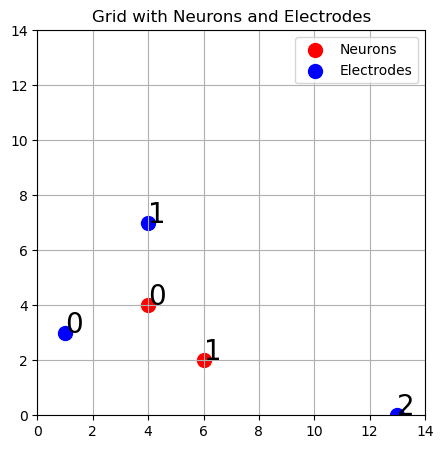

In [273]:
grid.plot_grid(figsize=(5, 5))

We can show how the emitted signal from each neuron is being recorded by each electrode with attenuation noise.

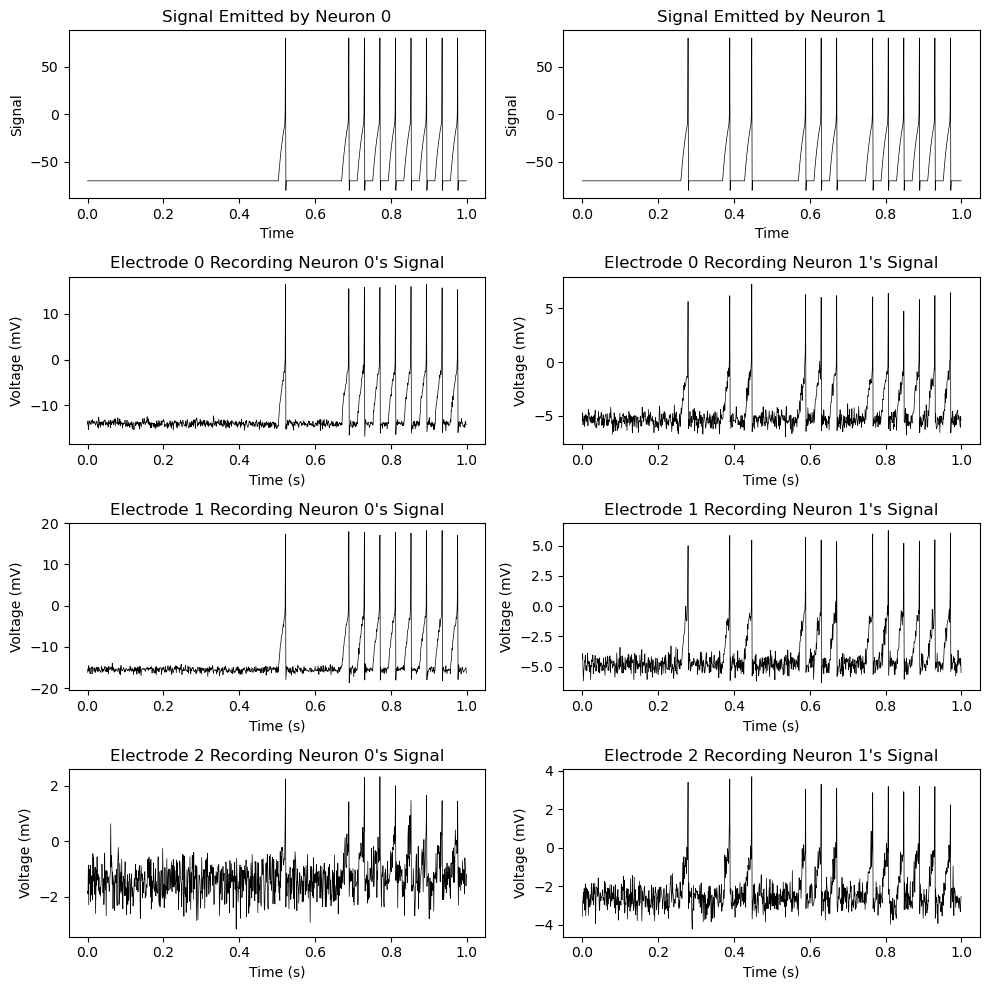

In [274]:
grid.show_raw_signals(figsize=(10, 10), combined=False)

The signals recorded by each electrode should be a combination of the neurons signals.

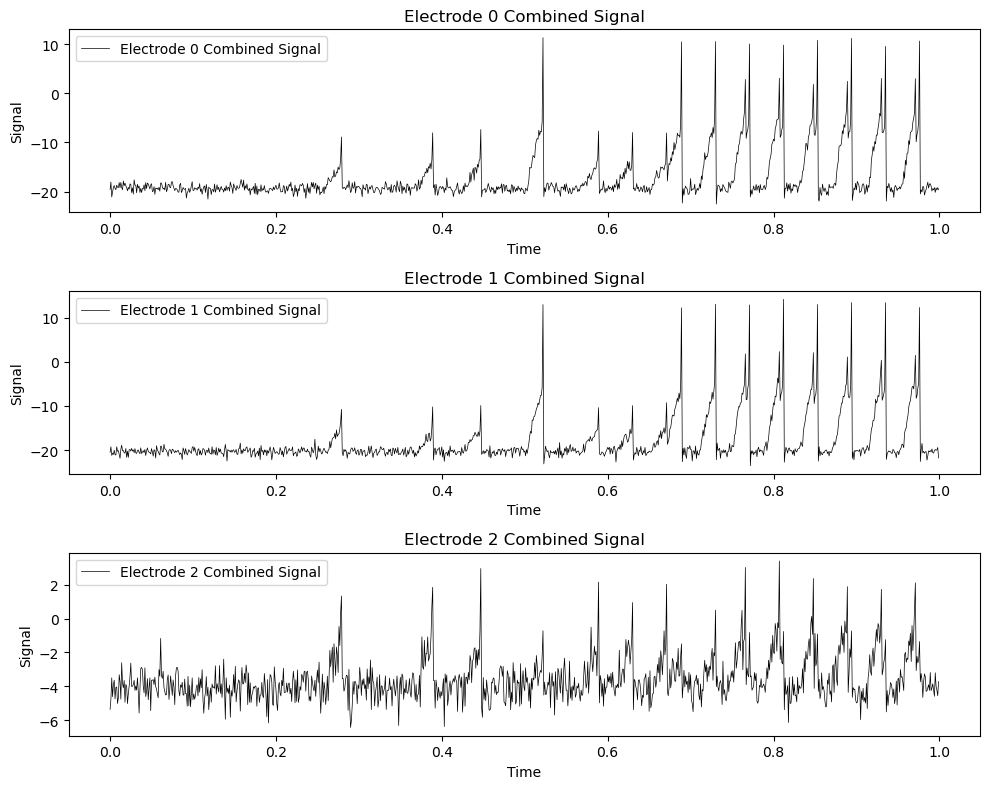

In [275]:
grid.show_raw_signals(figsize=(10, 8), combined=True)

# Spike Identification

In [276]:
class SpikeSorter():
    def __init__(self, threshold_factor, waveform_duration, sample_rate=25000):
        self.threshold_factor = threshold_factor
        self.sample_rate = sample_rate
        self.dt = 1 / self.sample_rate
        self.waveform_duration = waveform_duration

    ## needs modification
    def filter_signal(self, signal, type, low: int, high: int, order: int):
        # the nyquist frequency
        nyquist = 0.5 * self.sample_rate

        # form upper/lower frequency bounds
        lower = low / nyquist
        upper = high / nyquist

        if type == "bandpass":
            # filter the data using the butterworth filter
            b, a = scipy.signal.butter(order, [lower, upper], btype='band')

            # this compensates for phase shifting as it does forward and backwards pass
            filtered_signal = scipy.signal.filtfilt(b, a, signal, padlen=len(signal)-1)

            return filtered_signal
        else:
            print("Unknown Filter Type: ", type)

    def filter_signals(self, signals, type: str="bandpass", low: int=500, high: int=3000, order: int=4, visualise: bool=True):
        filtered_signals = []
        for signal in signals:
            filtered_signals.append(self.filter_signal(signal=signal, type=type, low=low, high=high, order=order))

        if visualise:
            fig, axs = plt.subplots(len(filtered_signals), 1, figsize=(8, 12))

            if len(filtered_signals) == 1:
                axs = [axs]

            for electrode_id, ax in enumerate(axs):
                filtered_signal = filtered_signals[electrode_id]
                time = np.arange(len(filtered_signal))
                ax.plot(time, filtered_signal, label=f'Electrode {electrode_id} Combined Signal')
                ax.set_title(f'Electrode {electrode_id} Combined Signal')
                ax.set_xlabel('Time')
                ax.set_ylabel('Signal')
                ax.legend()

            plt.tight_layout()
            plt.show()
            
        return filtered_signals
    
    def get_threshold_value(self, signal: np.ndarray, is_negative: bool=False) -> float:
        # calculate robust s.d. using the mean absolute deviation (MAD)
        sigma = np.median(np.abs(signal - np.median(signal)) / 0.6745)

        df = pd.DataFrame(signal)
        df.to_csv("../data/example_signal.csv")

        # set the threshold for this channel
        if is_negative:
            return -1 * self.threshold_factor * sigma # not sure if its always negative??
        else:
            return self.threshold_factor * sigma
    
    def detect_spikes(self, y: np.ndarray, threshold: float, minimum_gap: int=1, use_absolute_threshold: bool=False, flipped: bool=False) -> np.ndarray:
        """
        Detects spikes (or troughs) in a given signal.

        Parameters
        ----------
        y: np.ndarray
            The input signal.
        threshold: float
            The threshold value for spike detection. If `use_absolute_threshold` is False, this is a relative value.
        minimum_gap: int, optional
            The minimum number of samples between spikes. Default is 1.
        use_absolute_threshold : bool, optional
            If True, `threshold` is an absolute value. If False, `threshold` is a relative value. Default is False.
        flipped: bool, optional
            If True, the function will detect troughs (downward spikes) instead of peaks (upward spikes). Default is False.

        Returns
        -------
        np.ndarray
            An array of indices in `y` where spikes were detected.

        Raises
        ------
        ValueError
            If `y` is an unsigned array.

        Notes
        -----
        This function uses a first order difference method to detect spikes. It first computes the first differential of `y`, then finds the indices where the differential changes sign (indicating a peak or trough). It then filters these indices based on the `threshold` value and the `minimum_gap` between spikes.

        If `flipped` is True, the function detects troughs instead of peaks. This is done by reversing the sign of the differential and the `threshold` value.

        The function returns an array of indices in `y` where spikes (or troughs) were detected.
        """

        # Check if y is unsigned array
        if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
            raise ValueError("y must be signed")
        
        # Convert relative threshold to absolute if necessary
        if not use_absolute_threshold:
            threshold = threshold * (np.max(y) - np.min(y)) + np.min(y)

        # Compute the first differential
        dy = np.diff(y)

        # Propagate left and right values successively to fill all plateau pixels (no gradient)
        zeros, = np.where(dy == 0)

        # Check if the signal is totally flat
        if len(zeros) == len(y) - 1:
            return np.array([], dtype=np.int64)
        
        # Find the peaks or troughs
        if flipped:
            extrema = np.where((np.hstack([dy, 0.0]) > 0.0) & (np.hstack([0.0, dy]) < 0.0) & (np.less(y, threshold)))[0]
        else:
            extrema = np.where((np.hstack([dy, 0.0]) < 0.0) & (np.hstack([0.0, dy]) > 0.0) & (np.greater(y, threshold)))[0]

        # Handle multiple peaks or troughs, respecting the minimum distance
        if extrema.size > 1 and minimum_gap > 1:
            sorted_extrema = extrema[np.argsort(y[extrema])][::-1]
            rem = np.ones(y.size, dtype=bool)
            rem[extrema] = False

            for extremum in sorted_extrema:
                if not rem[extremum]:
                    sl = slice(max(0, extremum - minimum_gap), extremum + minimum_gap + 1)
                    rem[sl] = True
                    rem[extremum] = False

            extrema = np.arange(y.size)[~rem]

        return extrema

    def __get_true_labels(self, merged_spikes: np.ndarray, neuron_spikes: List[List]) -> List[Tuple]:
        true_labels = []
        for i, neuron in enumerate(neuron_spikes):
            for spike in neuron:
                if spike in merged_spikes:
                    true_labels.append((spike, i))
        

        # ensure the list is returned in order of index
        true_labels = sorted(true_labels, key=lambda x: x[0])
        return [i[1] for i in true_labels]

    def merge_spike_indices(self, spike_indices: np.ndarray[np.ndarray], neuron_spikes: List[List], tolerance: int=1) -> np.ndarray:
        """
        Merge spike indices from multiple channels into a single array. 
        If the points are close together only the midpoint is added.

        Parameters:
        -----------
        spike_indices: list of numpy arrays
            Each numpy array contains spike indices for a single channel.
        tolerance: int, optional
            The maximum distance between spike indices that will be considered as the same spike.
            Indices within this distance will be replaced by their midpoint.

        Returns:
        --------
        numpy array
            A single array of merged spike indices.
        """

        # flatten all indices into a single list
        all_indices = np.concatenate(spike_indices)
        
        # sort the indices
        all_indices.sort()
        
        # initialise the output list with the first index
        merged_indices = [all_indices[0]]
        
        # go through the sorted list and merge indices that are close together
        for index in all_indices[1:]:
            if index - merged_indices[-1] <= tolerance:
                # if the current index is close to the last one in the output list, replace the last one with their average (rounded to nearest integer)
                merged_indices[-1] = round((merged_indices[-1] + index) / 2)
            else:
                # if the current index is not close to the last one, add it to the output list
                merged_indices.append(index)
        
        true_labels = self.__get_true_labels(merged_indices, neuron_spikes)
        
        return np.array(merged_indices, dtype=int), true_labels

    def get_waveforms(self, y: np.ndarray, spike_indices: np.ndarray, window_shift_ratio: float=0.5) -> Tuple[np.ndarray[np.ndarray], List[dict]]:
        """
        Extracts waveforms from a signal at given indices.

        Parameters
        ----------
        y : np.ndarray
            The input signal.
        spike_indices : np.ndarray
            The indices in `y` where spikes were detected.
        duration : int
            The duration of the waveform in milliseconds.
        sample_rate : int
            The sample rate of the signal in Hz.
        window_shift_ratio : float, optional
            The ratio of the window size to shift the window to the left of the spike. Default is 0.5.

        Returns
        -------
        waveforms : np.ndarray
            A nested numpy array of extracted waveforms.
        waveform_info : list of dict
            A list of dictionaries containing information about each extracted waveform.

        Notes
        -----
        The dictionaries of waveform_info contain the starting and finishing index of the waveform, its greatest positive 
        and negative amplitudes and the values of the waveform (corresponding to the data in `waveforms`).
        
        """

        # Calculate the number of samples to extract around each spike
        window_size = int(self.sample_rate * self.waveform_duration / 10000)

        # Calculate the number of samples to shift the window
        shift = int(window_size * window_shift_ratio)

        waveforms = []
        waveform_info = []

        # Iterate over the spike indices
        for i in spike_indices:

            # Calculate the start and end of the window
            start = int(i - shift)
            end = int(start + window_size)

            # Extract the waveform
            waveform = y[start:end]

            # Append the waveform to the list
            waveforms.append(waveform)

            # Store information about the waveform
            spike_info = {
                'spike_start': start,
                'spike_end': end,
                'lowest_value': np.min(waveform),
                'highest_value': np.max(waveform),
                'values': waveform
            }

            waveform_info.append(spike_info)

        # Convert the lists to numpy arrays
        waveforms = np.array(waveforms)

        return waveforms, waveform_info

    def get_all_waveforms(self, signals: np.ndarray, spike_indices: np.ndarray):
        waveforms = []
        waveform_info = []

        # loop through each of the electrode signals
        for i, signal in enumerate(signals):

            # get waveforms for this channel
            waveforms_channel, waveform_info_channel = self.get_waveforms(y=signal, spike_indices=spike_indices)
            
            # append the waveforms and waveform_info to the lists
            waveforms.append(waveforms_channel)
            waveform_info.append(waveform_info_channel)

        # convert waveforms and waveform_info to numpy arrays
        waveforms = np.array(waveforms)
        waveform_info = np.array(waveform_info)

        return waveforms, waveform_info
        
    def get_spikes(self, signals, visualise=False, figsize: Tuple[int]=(8, 12)):

        # initialise spikes as an empty list
        spikes = []
        # loop through each of the channels (electrodes)
        for i, signal in enumerate(signals):
            threshold = self.get_threshold_value(signal=signal, is_negative=False)

            # detect spikes in this channel
            spikes_channel = self.detect_spikes(signal, threshold, use_absolute_threshold=True)

            # append the detected spikes to the list
            spikes.append(spikes_channel)
        
        if visualise:
            self.show_spikes(signals, spikes, figsize)

        return spikes
    
    def show_spikes(self, signals, spikes, figsize):
        # create a figure with one subplot for each electrode
        fig, axs = plt.subplots(len(spikes), 1, figsize=figsize)

        # handle the case where there's only one electrode
        if len(spikes) == 1:
            axs = [axs]

        # plot the combined signals from the electrodes
        for electrode_id, ax in enumerate(axs):

            # get the combined signal
            combined_signal = signals[electrode_id]

            # plot the combined signal
            time = np.arange(len(combined_signal)) / self.sample_rate
            ax.plot(time, combined_signal, label=f'Electrode {electrode_id} Combined Signal', c="k", lw=0.5)

            threshold = self.get_threshold_value(signal=combined_signal, is_negative=False)
            ax.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0, label=f"Threshold = {round(threshold, 3)} mV")

            ax.scatter(time[spikes[electrode_id]], combined_signal[spikes[electrode_id]], c="red")

            ax.set_title(f'Electrode {electrode_id} Recorded Signal')
            ax.set_xlabel('Time')
            ax.set_ylabel('Signal')
            ax.legend()

        # Adjust the layout and show the plot
        plt.tight_layout()
        plt.show()


In [277]:
# get the signals recorded from each of the electrodes from the grid object 
signals = [grid.electrode_dict[i]["signal"] for i in grid.electrode_dict.keys()]

In [278]:
# initialise a Spike Sorter object
sorter = SpikeSorter(threshold_factor=3, sample_rate=sample_rate, waveform_duration=70)

In [303]:
# this needs to be adjusted and the parameters tweaked. And the simulated data doesn't really need filtering
# signals = sorter.filter_signals(signals=signals)

We can plot each of the electrode recordings signals, with the identified spikes which exceed a given threshold value.

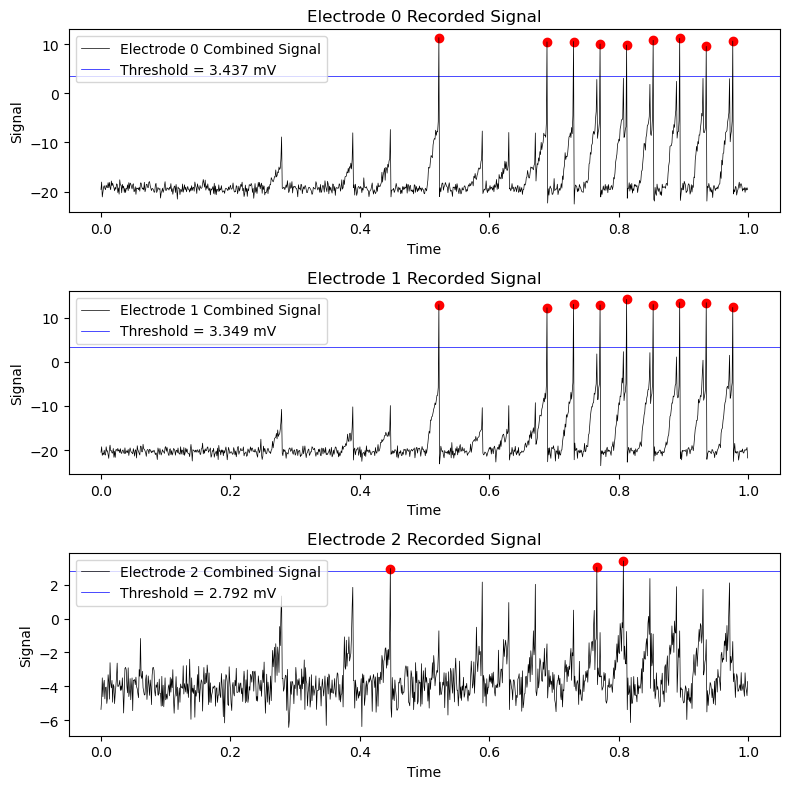

In [279]:
spikes = sorter.get_spikes(signals, visualise=True, figsize=(8, 8))

The number and positions of identified spikes is different for each of the electrodes. Although some spikes may have not been isolated the spike detector, this does not mean the electrode has not recorded the event, just that noise to amplitude ratio is not significant. Therefore, we will combine the positions of all the spikes, as we can cross reference how the spikes are recorded by each electrode.

In [280]:
# get the actual time positions of the spikes (this acts as labelled data)
neuron_spikes = [grid.neurons_dict[neuron_id]["spikes"] for neuron_id in grid.neurons_dict.keys()]

# convert the spikes into a numpy array
spike_indices = np.array(spikes)

# get the locations of all the spikes detected by all channels, and true spike posititons
merged_spike_indices, true_labels = sorter.merge_spike_indices(spike_indices, neuron_spikes, tolerance=1)

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_12959/3469036481.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_indices = np.array(spikes)


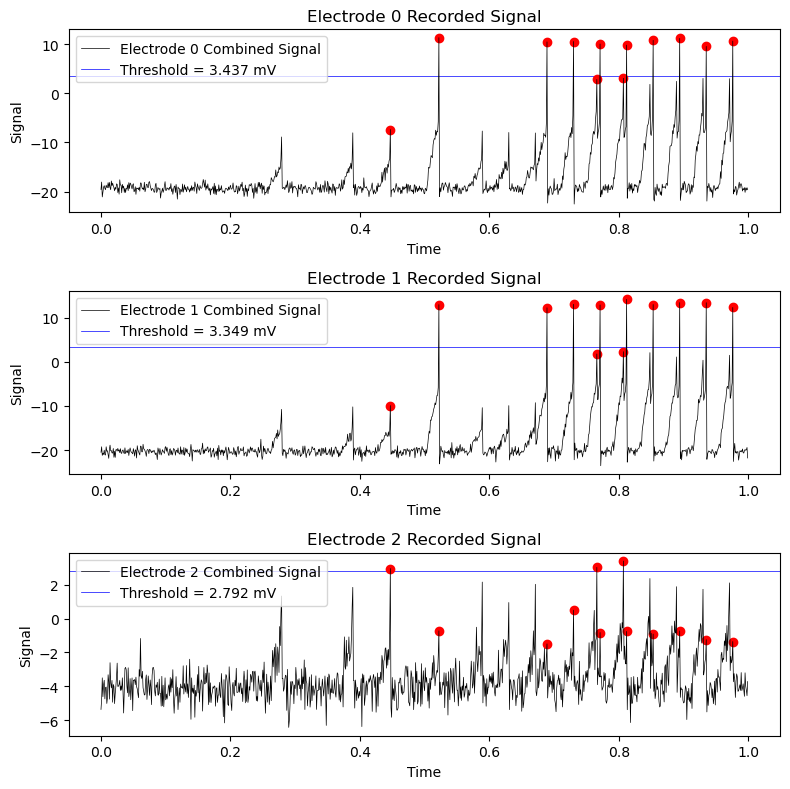

In [281]:
sorter.show_spikes(signals, [merged_spike_indices] * len(signals), figsize=(8, 8))

In [282]:
# extract the waveform data from each of the identified spikes across all channels
waveforms, waveform_info = sorter.get_all_waveforms(signals, merged_spike_indices)

The extracted waveforms can then be displayed. Using the labelled data, the neuron of origin can be shown.

TypeError: 'AxesSubplot' object is not subscriptable

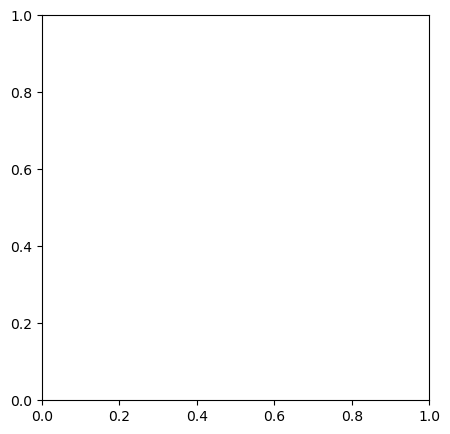

In [283]:
# determine the number of channels
n_channels = waveforms.shape[0]

# calculate the size of the grid
grid_size = int(np.sqrt(n_channels))

# create a figure and subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# get unique labels
unique_labels = np.unique(true_labels)

# create a colormap
colormap = plt.cm.get_cmap('viridis', len(unique_labels))

# create a dictionary mapping each label to a color
label_to_color = {label: colormap(i) for i, label in enumerate(unique_labels)}

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(grid_size):
    for j in range(grid_size):
        channel_idx = i * grid_size + j
        # iterate over the waveforms in this channel and plot each on top of each other
        for idx, waveform in enumerate(waveforms[channel_idx]):
            t = np.arange((- sorter.waveform_duration / 2), (sorter.waveform_duration / 2) ) * sorter.dt * 1000 

            # get the color for this waveform based on its label
            color = label_to_color[true_labels[idx]]

            # plot the waveform
            axs[i, j].plot(t, waveform, lw=.5, c=color)

        axs[i, j].set_xlabel('Time (ms)')
        axs[i, j].set_ylabel('Amplitude')
        axs[i, j].set_title(f'Waveforms (Electrode {channel_idx})')

plt.tight_layout()
plt.show()

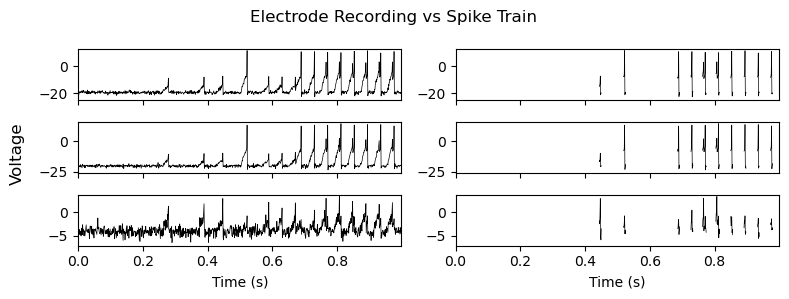

In [284]:
# determine the number of channels
n_channels =  waveforms.shape[0]

# create a figure and subplots
fig, axs = plt.subplots(n_channels, 2, figsize=(8, 1 * n_channels), sharex=True)

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for electrode_id in range(n_channels):
    signal = grid.electrode_dict[electrode_id]["signal"]

    # plot the raw data for this channel
    axs[electrode_id, 0].plot(time, np.array(signal), label='Raw Data', c='k', lw=0.5)

    # iterate through each spike and plot its waveform for this channel
    for spike in waveform_info[electrode_id]:
        spike_window = slice(spike["spike_start"], spike["spike_end"])
        axs[electrode_id, 1].plot(time[spike_window], signal[spike_window], c='k', lw=0.5)

    # add x labels to bottom plots
    if electrode_id == n_channels - 1:
        axs[electrode_id, 0].set_xlabel('Time (s)')
        axs[electrode_id, 1].set_xlabel('Time (s)')

    axs[electrode_id, 0].set_ylim((min(signal) + (min(signal) * 0.1) , max(signal) + (max(signal) * 0.1)))
    axs[electrode_id, 1].set_ylim((min(signal) + (min(signal) * 0.1) , max(signal) + (max(signal) * 0.1)))
    axs[electrode_id, 0].set_xlim((0, max(time)))
    axs[electrode_id, 1].set_xlim((0, max(time)))

fig.supylabel("Voltage")
fig.suptitle("Electrode Recording vs Spike Train")
plt.tight_layout()
plt.show()

# Feature Extraction

In [285]:
print(f"{waveforms.shape} ==> (# electrodes, # Spikes, Spike Window Size)")

(3, 12, 7) ==> (# electrodes, # Spikes, Spike Window Size)


In [286]:
n_components = 3

b = []
explained_variance_ratios = []
for i in range(waveforms.shape[0]):
    waveform = waveforms[i]

    # initialise PCA
    pca = PCA(n_components=n_components)

    b.append(pca.fit_transform(waveform))

    explained_variance_ratios.append(pca.explained_variance_ratio_)

    # umap = UMAP(n_components=n_components)
    # b.append(umap.fit_transform(waveform))

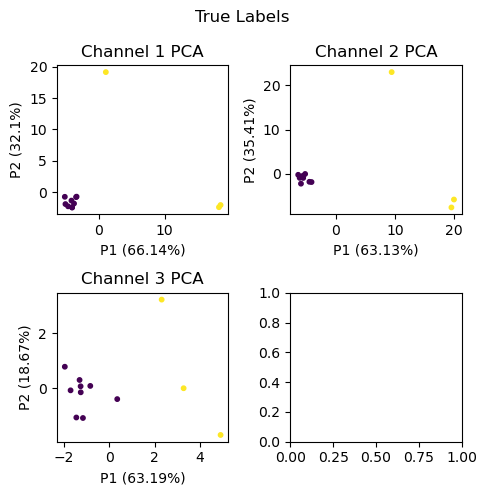

In [287]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]

    unique_labels = np.unique(true_labels)
    colormap = plt.cm.get_cmap('viridis', len(unique_labels))
    label_to_color = {label: colormap(i) for i, label in enumerate(unique_labels)}
    colors = [label_to_color[label] for label in true_labels]

    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=10, c=colors)

plt.suptitle("True Labels")
plt.tight_layout()
plt.show()

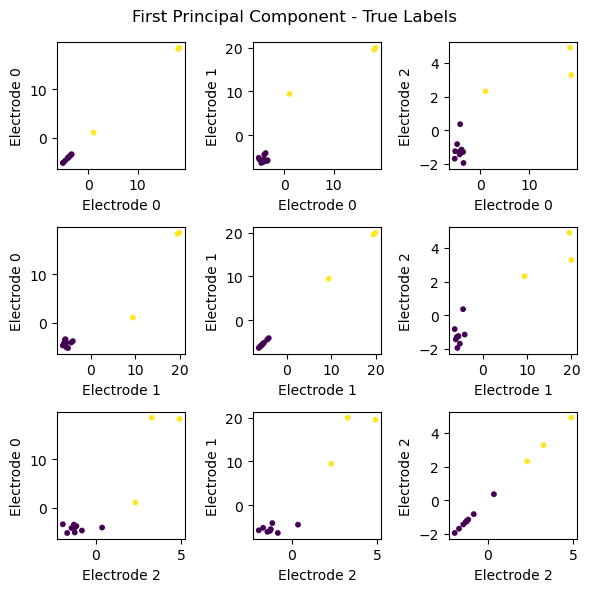

In [288]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(6, 6))

# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):

        unique_labels = np.unique(true_labels)
        colormap = plt.cm.get_cmap('viridis', len(unique_labels))
        label_to_color = {label: colormap(i) for i, label in enumerate(unique_labels)}
        colors = [label_to_color[label] for label in true_labels]

        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(b[i][:, 0], b[j][:, 0], c=colors, s=10)
        axs[i, j].set_xlabel(f"Electrode {i}")
        axs[i, j].set_ylabel(f"Electrode {j}")

plt.suptitle("First Principal Component - True Labels")
plt.tight_layout()
plt.show()

# Clustering

In [289]:
from sklearn.mixture import GaussianMixture 
from sklearn.preprocessing import StandardScaler

def mog(x: np.ndarray, k: int) -> Tuple[np.ndarray]:
    """
    Fit Mixture of Gaussian model
    ind, m, S, p = mog(x, k) fits a Mixture of Gaussian model to the data
    in x using k components. The output ind contains the MAP assignments of the
    datapoints in x to the found clusters. The outputs m, S, p contain
    the model parameters.

    Parameters
    ----------
    x: np.array 
        The datapoints -> N (Number of datapoints) x D (dimensionality of the data)
    k: int
        Number of clusters

    Returns
    ----------
    ind: np.array 
        Cluster indicators
    m: np.array
        Cluster means    (k x D)
    S: np.array 
        Cluster covarience matricies    (D x D x k)
    p: np.array 
        Cluster prior probabilities    (k x 1)
    """
    
    # fit the model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(x)

    # get the MAP assignments of the data points
    ind = gmm.predict(x)

    # get the model parameters
    m = gmm.means_
    S = gmm.covariances_
    p = gmm.weights_


    return (ind, m, S, p)

from scipy.stats import multivariate_normal

def compute_log_likelihood(x, m, S, p):
    """
    Compute the log-likelihood of the data under the model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k by 1

    Returns:
        LL (float): Log-likelihood
    """
    k = m.shape[0]
    n = x.shape[0]
    LL = 0
    for i in range(n):
        temp = 0
        for j in range(k):
            try:
                temp += p[j] * multivariate_normal(m[j], S[j]).pdf(x[i])
            except:
                print(f"Covariance matrix for component {j} is not positive definite:")
                print(S[j])
                return
        LL += np.log(temp)
    return LL

def mog_bic(x, m, S, p):
    """
    Compute the BIC for a fitted Mixture of Gaussian model
    bic, LL = mog_bic(x,k) computes the the Bayesian Information 
    Criterion value and the log-likelihood of the fitted model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k

    Returns:
        bic (float): BIC
        LL (float): Log-likelihood
    """
    n, d = x.shape
    k = m.shape[0]

    # Compute the log-likelihood
    LL = compute_log_likelihood(x, m, S, p)

    # Compute the number of parameters
    P = k * (d + (d * (d + 1) / 2) + 1)

    # Compute the BIC
    bic = -2 * LL + P * np.log(n)
    
    return bic, LL

In [290]:
x = np.array(b)
x = np.transpose(x, (1, 0, 2)).reshape((-1, x.shape[0] * x.shape[2]))

In [291]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

# ind, m, S, p = mog(x, 6)
# bic, ll = mog_bic(x, m, S, p)

K = [1, 2, 3, 4, 5, 6, 7]
BIC = np.zeros((len(K)))
LL = np.zeros((len(K)))

# loop over the number of clusters
for i, k in enumerate(K):
    # fit the GMM to the data
    ind, m, S, p = mog(x, k)

    # compute the BIC and log-likelihood
    bic, ll = mog_bic(x, m, S, p)

    # store the results
    BIC[i] = bic
    LL[i] = ll

print("BIC: \n", BIC)
print("Log-likelihood: \n", LL)

BIC: 
 [ 256.27876272   98.20527068    4.30974189 -254.07193027 -199.02358323
 -205.16378939 -121.16634014]
Log-likelihood: 
 [-59.80444849  87.5672304  202.84992766 400.37569661 441.18645596
 512.59149191 538.92770015]


**The current method of finding optimal number of clusters is wack**

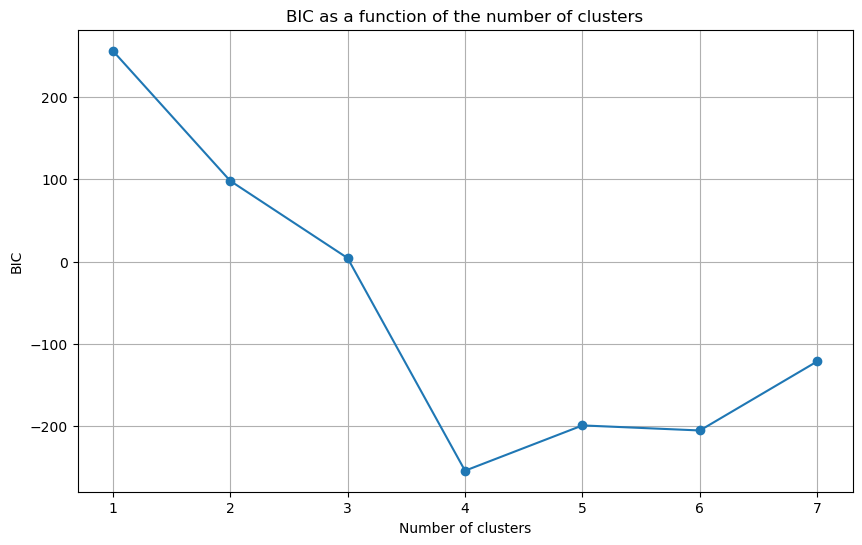

In [292]:
# plot the BIC as a function of the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K, BIC, marker='o')
plt.title('BIC as a function of the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.grid(True)
plt.show()

In [293]:
# optimal_k = K[np.argmin(BIC)]
optimal_k = 2

# # Refit the model with the optimal number of clusters
ind, m, S, p = mog(x, optimal_k)

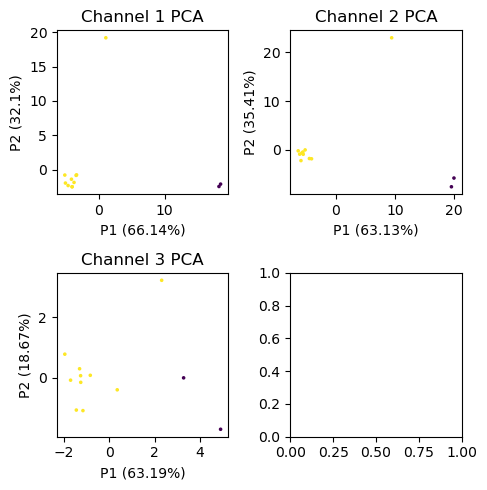

In [294]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]
    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=10, c=ind, cmap='viridis', marker='.', alpha=1) 

plt.tight_layout()
plt.show()

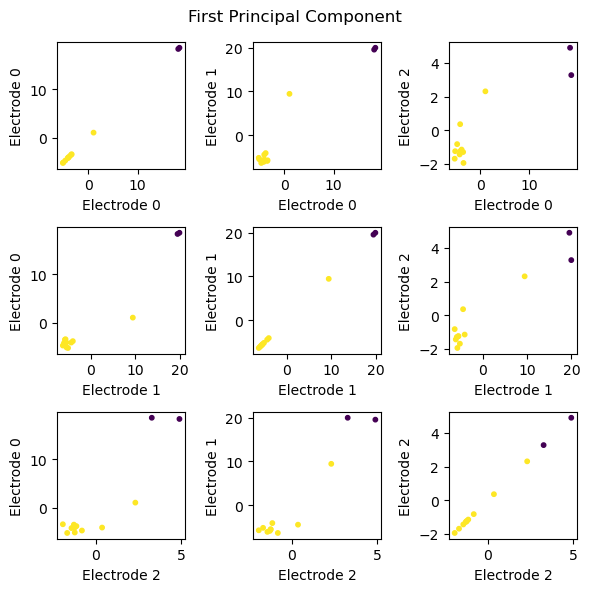

In [295]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(6, 6))

# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):
        
        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(b[i][:, 0], b[j][:, 0], c=ind, s=10, label=ind)
        axs[i, j].set_xlabel(f"Electrode {i}")
        axs[i, j].set_ylabel(f"Electrode {j}")

plt.suptitle("First Principal Component")
plt.tight_layout()
plt.show()

In [296]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, ind.tolist())
precision = precision_score(true_labels, ind.tolist(), average="weighted")
recall = recall_score(true_labels, ind.tolist(), average="weighted")
f1 = f1_score(true_labels, ind.tolist(), average="weighted")

print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1: {f1}")                

Accuracy: 0.08333333333333333 
Precision: 0.025000000000000005 
Recall: 0.08333333333333333 
F1: 0.03846153846153846


## Distance

Calculate the strength of each neuron's signal on each electrode by determining the mean peak amplitude of each spike.

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_12959/2113355906.py:183: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  signal_baseline = mode(self.electrode_dict[i]["signal"])[0][0]


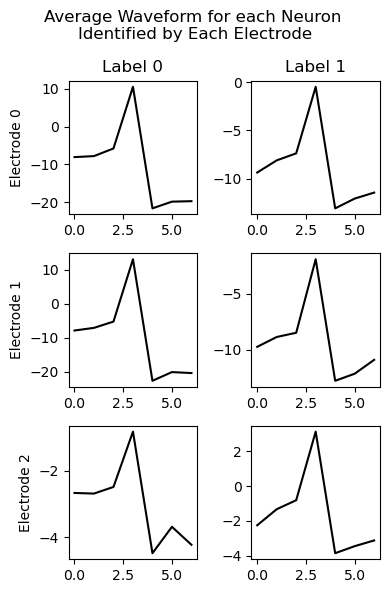

In [297]:
grid.determine_signal_strengths(true_labels, waveforms, visualise=True)

In [298]:
grid.electrode_dict[0]["avg_waveform_peak"]

{0: 10.472216798165592, 1: -0.4939474866719807}

* For each neuron, choose the 3 electrodes with the largest signal strengths
* Use the electrode with the strongest signal as the reference, compute the ratio signal 1 against signal 2 and use this to compute the line of relative distance between the electrodes and the neuron.
* Do the same using the first and third electrodes.
* The point of intersection between these two lines is the location of the neuron.

In [299]:
class Triangulator:
    def __init__(self, grid, labels) -> None:
        self.grid = grid
        self.labels = labels

    def __draw_circle(self, plot, point, radius):
        x, y = point[0], point[1]
        return plot.Circle((x, y), radius, fill=False, edgecolor='grey')
    
    def __signal_strength_ratio(self, signal_1, signal_2):
        if grid.decay_type == "square":
            ratio = np.sqrt(signal_1 / signal_2)
        else:
            print("Unknown Decay Type:", self.grid.decay_type)

        return ratio
    
    def __is_point_on_line(self, point, line_point1, line_point2):
        """ Check if a point is on a line between two other points """
        
        # get the coordinates of the points
        x, y = point
        x1, y1 = line_point1
        x2, y2 = line_point2

        # compute the cross product and the dot product
        cross_product = (y - y1) * (x2 - x1) - (x - x1) * (y2 - y1)
        dot_product = (x - x1) * (x2 - x1) + (y - y1)*(y2 - y1)

        # compute the squared length of the line segment
        squared_length = (x2 - x1)**2 + (y2 - y1)**2

        # check if the point is on the line segment
        if abs(cross_product) > 1e-10 or dot_product < 0 or dot_product > squared_length:
            return False
        else:
            return True

    def __find_intersection(self, lines):
        line1, line2 = lines[0], lines[1]

        m1, b1 = line1
        m2, b2 = line2

        if m1 == m2:
            print('Lines are parallel and do not intersect.')
            return None
        
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
        return x, y
    
    def __calculate_straight_line(self, point_1, point_2):
        x_1, y_1, x_2, y_2 = point_1[0], point_1[1], point_2[0], point_2[1]

        if x_2 - x_1 == 0:
            return float('inf'), x_1  # return 'inf' as m and x_1 as 'b' for vertical line
        elif y_2 - y_1 == 0:
            m = 0
            b = y_1
        else:
            m = (y_2 - y_1) / (x_2 - x_1)
            b = y_1 - (m * x_1)

        return m, b

    def __calculate_perpendicular(self, point, m_original, b_original):
        x, y = point

        # handle the case of the original line being vertical
        if m_original == float('inf'):
            m_perp = 0
            b_perp = y

        # handle the case of the original line being horizontal
        elif m_original == 0:
            m_perp = float('inf')
            b_perp = x

        # for all other lines
        else:
            m_perp = -1 / m_original
            b_perp = y - m_perp * x

        return m_perp, b_perp

    def __calculate_tangent(self, point_1, point_2, radius):
        x_c, y_c = point_1[0], point_1[1]

        # gradient and intercept of line
        m, b = self.__calculate_straight_line(point_1, point_2)

        # coefficients of the quadratic equation
        A = 1 + m**2
        B = 2 * (m * (b - y_c) - x_c)
        C = x_c**2 + (b - y_c)**2 - radius**2

        # calculate the discriminant
        D = B**2 - 4 * A * C

        # list to store the intersections of circle and line
        intersections = []

        # no intersection (shouldn't happen)
        if D < 0:
            print('The line and the circle do not intersect.')
            return None
        # the line is tangent to the circle
        elif D == 0:  
            x = -B / (2 * A)
            y = m * x + b
            intersections.append((x, y))
        # the line intersects the circle at two points
        else:  
            x1 = (-B + D**0.5) / (2 * A)
            y1 = m * x1 + b
            intersections.append((x1, y1))
            x2 = (-B - D**0.5) / (2 * A)
            y2 = m * x2 + b
            intersections.append((x2, y2))
        
        for intersection in intersections:
            if self.__is_point_on_line(intersection, point_1, point_2):
                return self.__calculate_perpendicular(intersection, m, b)

    def __euclidean_distance(self, point_1, point_2):
        return np.sqrt((point_1[0] - point_2[0])**2 + (point_1[1] - point_2[1])**2)

    def show_grid(self, show_construction=True) -> None:
        for neuron_id in self.labels:
            fig, ax = plt.subplots(figsize=(6,6))
            
            # extract neuron and electrode positions
            neuron_positions = [(v["row"], v["col"]) for v in self.grid.neurons_dict.values()]
            electrode_positions = [(v["row"], v["col"]) for v in self.grid.electrode_dict.values()]

            # if there are neurons, plot them
            if neuron_positions:
                neuron_rows, neuron_cols = zip(*neuron_positions) # unzip into x and y coordinates
                plt.scatter(neuron_rows, neuron_cols, color='r', label='Neurons', s=100)

                # add text labels for neurons
                for i, (x, y) in enumerate(neuron_positions):
                    plt.text(x, y, f'{i}', fontsize=20)

            # if there are electrodes, plot them
            if electrode_positions:
                electrode_rows, electrode_cols = zip(*electrode_positions) # unzip into x and y coordinates
                plt.scatter(electrode_rows, electrode_cols, color='b', label='Electrodes', s=100)

                # add text labels for electrodes
                for i, (x, y) in enumerate(electrode_positions):
                    plt.text(x, y, f'{i}', fontsize=20)

            # draw lines for each pair of points
            for pair in self.triangulate_info[neuron_id]["electrode_pairs"]:
                point1, point2 = pair
                plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-')

            # show construction lines and circles 
            if show_construction:
                # plot circles
                for info in self.triangulate_info[neuron_id]["circle_info"]:
                    circle = self.__draw_circle(plt, info[0], info[1])
                    ax.add_patch(circle)
                
                # plot the perpendicular lines
                for slope, intercept in self.triangulate_info[neuron_id]["perpendicular_lines"]:
                    x = np.linspace(0, self.grid.width, 1000)
                    y = slope * x + intercept
                    plt.plot(x, y, c="blue", lw=0.5)

            # plot the intersection point
            intersection_coords = self.triangulate_info[neuron_id]["intersection_point"]
            plt.scatter(intersection_coords[0], intersection_coords[1], c="purple", s=100, label="Estimated Position")

            plt.xlim(0, self.grid.width - 1)
            plt.ylim(0, self.grid.height - 1)
            plt.grid(True)
            plt.legend()
            plt.title(f"Identifying Neuron {neuron_id} Location")
            plt.show()
    
    def triangulate(self):
        self.triangulate_info = {}

        # iterate through each of the identified neurons
        for neuron_id in range(len(self.labels)):
            self.triangulate_neuron(neuron_id)

    def triangulate_neuron(self, neuron_id):
        self.triangulate_info[neuron_id] = {
            "electrode_pairs": [],
            "perpendicular_lines": [],
            "circle_info": [],
        }

        # get the items of the electrode dictionary as a list of tuples
        items = list(grid.electrode_dict.items())

        # sort the electrodes by the strength of the signal recorded
        sorted_items = sorted(items, key=lambda item: item[1]["avg_waveform_peak"][neuron_id])

        # convert the sorted items back into a dictionary.
        sorted_dict = dict(sorted_items)

        # ids for the electrodes in order of signal strength 
        electrodes_by_strength = list(sorted_dict.keys())[::-1]
        self.triangulate_info[neuron_id]["electrodes_by_strength"] = electrodes_by_strength

        # distance between first electrode (a) and second electrode (b)
        x_a, y_a = grid.electrode_dict[electrodes_by_strength[0]]["row"], grid.electrode_dict[electrodes_by_strength[0]]["col"]
        x_b, y_b = grid.electrode_dict[electrodes_by_strength[1]]["row"], grid.electrode_dict[electrodes_by_strength[1]]["col"]

        d_ab = self.__euclidean_distance((x_a, y_a), (x_b, y_b))
        self.triangulate_info[neuron_id]["electrode_pairs"].append(((x_a, y_a), (x_b, y_b)))

        # ratio of signal strength between the electrodes a and b
        s_a =  grid.electrode_dict[electrodes_by_strength[0]]["baseline_to_peak"][neuron_id]
        s_b =  grid.electrode_dict[electrodes_by_strength[1]]["baseline_to_peak"][neuron_id]

        ab_ratio = self.__signal_strength_ratio(s_a, s_b)

        # neurons distance from electrode a along the line connecting a and b
        r_ab = d_ab / (1 + ab_ratio)
        self.triangulate_info[neuron_id]["perpendicular_lines"].append(self.__calculate_tangent((x_a, y_a), (x_b, y_b), r_ab))
        self.triangulate_info[neuron_id]["circle_info"].append(((x_a, y_a), r_ab))

        # distance between first electrode (a) and third electrode (c)
        x_c, y_c = grid.electrode_dict[electrodes_by_strength[2]]["row"], grid.electrode_dict[electrodes_by_strength[2]]["col"]
        d_ac = np.sqrt((x_a - x_c)**2 + (y_a - y_c)**2)
        self.triangulate_info[neuron_id]["electrode_pairs"].append(((x_a, y_a), (x_c, y_c)))

        # ratio of signal strength between the electrodes a and b
        s_c =  grid.electrode_dict[electrodes_by_strength[2]]["baseline_to_peak"][neuron_id]

        ac_ratio = self.__signal_strength_ratio(s_a, s_c)

        # neurons distance from electrode a along the line connecting a and b
        r_ac = d_ac / (1 + ac_ratio)
        self.triangulate_info[neuron_id]["perpendicular_lines"].append(self.__calculate_tangent((x_a, y_a), (x_c, y_c), r_ac))
        self.triangulate_info[neuron_id]["circle_info"].append(((x_a, y_a), r_ac))

        self.triangulate_info[neuron_id]["intersection_point"] = self.__find_intersection(self.triangulate_info[neuron_id]["perpendicular_lines"])

    def assess_triangulation(self, show_results=False):
        # iterate through each of the identified neurons
        for neuron_id in range(len(self.labels)):

            # get the coordinates of the predicited neuron location
            calculated_position = self.triangulate_info[neuron_id]["intersection_point"]
            x_calc, y_calc = calculated_position[0], calculated_position[1]

            # get true location of the neuron
            x_true, y_true = self.grid.neurons_dict[neuron_id]["row"], self.grid.neurons_dict[neuron_id]["col"]

            # get distance between the two
            distance = self.__euclidean_distance((x_true, y_true), (x_calc, y_calc))

            # add to the dictionary
            self.triangulate_info[neuron_id]["distance_from_true_position"] = distance

            if show_results:
                print(f"Estimated position of neuron {neuron_id} is {distance} from the true position")

In [300]:
triangulator = Triangulator(grid=grid, labels=unique_labels)
triangulator.triangulate()
pprint(triangulator.triangulate_info)

{0: {'circle_info': [((4, 7), 2.4349798983579927),
                     ((4, 7), 3.2038686057215306)],
     'electrode_pairs': [((4, 7), (1, 3)), ((4, 7), (13, 0))],
     'electrodes_by_strength': [1, 0, 2],
     'intersection_point': (5.068326202404973, 3.155030475248779),
     'perpendicular_lines': [(-0.75, 6.956275127052509),
                             (1.2857142857142856, -3.3613889278433264)]},
 1: {'circle_info': [((13, 0), 7.4574291021580095),
                     ((13, 0), 6.848194723883088)],
     'electrode_pairs': [((13, 0), (1, 3)), ((13, 0), (4, 7))],
     'electrodes_by_strength': [2, 0, 1],
     'intersection_point': (5.781424111493835, 1.8734643297278915),
     'perpendicular_lines': [(4.0, -21.25223211624745),
                             (1.2857142857142856, -5.559795242192753)]}}


In [301]:
triangulator.assess_triangulation(show_results=True)

Estimated position of neuron 0 is 1.3620919104463307 from the true position
Estimated position of neuron 1 is 0.25256027971055 from the true position


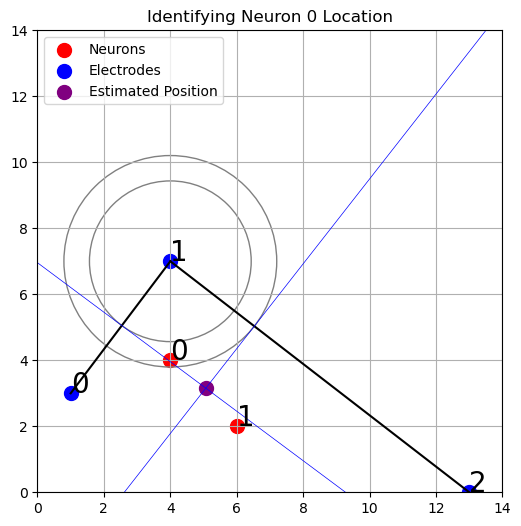

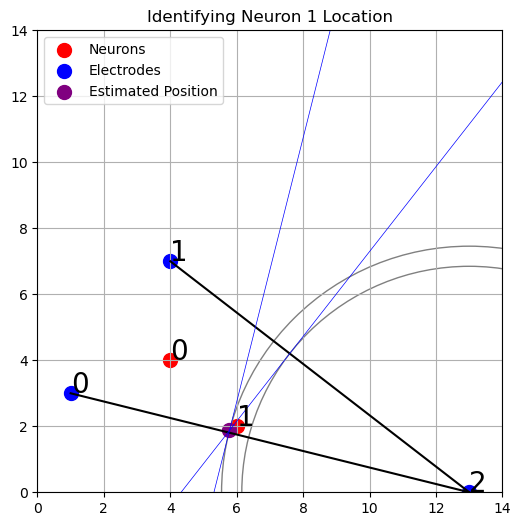

In [302]:
triangulator.show_grid()